# Rozdzielczość obrazu. Interpolacja.

## Cel zajęć:

* zapoznanie z pojęciem rozdzielczości przestrzennej (rozmiaru obrazu),
* metody interpolacji najbliższego sąsiada oraz dwuliniowa,
* zapoznanie z pojęciem rozdzielczości dpi (ang. dots per inch),
* zapoznanie z pojęciem rozdzielczości  poziomów jasności (dla obrazów w skali szarości),
* zadanie domowe: interpolacja dwusześcienna.

## Rodzielczość przestrzenna

Dyskretna reprezentacja obrazu to zwykle macierz dwu (N x M - obraz w skali szarości) lub trójwymiarowa (N x M x 3 - obraz kolorowy).
Przez rozdzielczość przestrzenną rozumie się liczbę pikseli z których składa się obraz.
Przykładowo rozdzielczość VGA to  640 x 480, Full HD to 1920 x 1080, a 4K to 3840 x 2160.
Rozdzielczość obrazu można modyfikować (zwiększać/zmniejszać), co nazywa się skalowaniem obrazu.
Warto wiedzieć, że zwiększenie rozdzielczości obrazu nie zwiększa ilości informacji, a jedynie liczbę pikseli (w sensie "lepiej nie będzie").
Ponadto skalowanie zawsze wprowadza pewne zniekształcenia, nawet przy zmniejszaniu rozmiaru.

W ramach niniejszego ćwiczenia zapoznamy się z metodami interpolacji, które są podstawą takich operacji jak: przybliżanie (zoom), zmiana rozdzielczości, rotacja obrazu, czy też korekcje geometryczne.
Jako przykład posłuży nam zmiana rozdzielczości, czyli inaczej mówiąc przepróbkowanie obrazu.
Dla przypomnienia - interpolacja to wykorzystanie znanych danych (wartości dla tzw. punktów węzłowych) do określania wartości w nieznanych lokalizacjach.

Zacznijmy od prostego przykładu.
Mamy obraz o rozdzielczości 500 x 500 pikseli, a chcemy go powiększyć do 750 x 750 pikseli -- tj. o współczynnik 1,5.
Wyobraźmy sobie zatem, że dysponujemy siatką 750 x 750 o takim samym "rozmiarze" pojedynczego piksela jak obraz oryginalny.
Następnie siatkę tą ,,ścieśniamy'', tak aby miała rozmiar 500 x 500.
W rezultacie otrzymana siatka będzie miała mniejszy rozmiar pojedynczego piksela niż obraz oryginalny.
Schematycznie przedstawiono to na poniższym rysunku.

![Ilustracja interpolacji](https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/img/interEx57.png)


Pokazuje on przykład interpolacji: a) obraz 5x5, b) oraz 7x7, c) obraz 7x7 zmiejszony do 5x5.


Chcemy teraz poszczególnym elementom nowej siatki przyporządkować piksele z obrazu wejściowego.
Jedną z możliwości jest poszukanie "najbliższego" piksela w oryginalnym obrazie i wzięcie jego wartości.
Przykład takiego postępowania zaprezentowano na  poniższym rysunku.

![Ilustracja najbliższego sąsiada](https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/img/inteNNEx.png)

Kilka słów wyjasnienia.
Kolorem ciemnoszarym oznaczono siatkę 5x5, a czarnym 7x7 (już po przeskalowaniu).
Nasze zadanie sprowadza się do zalezienia dla każdej kropki czarnej (umowny środek piksela), najbliżej leżącej kropki szarej - oznaczono to dla pierwszych trzech wierzszy obrazu liniami.

Po zrealizowaniu powyższego kroku dla całego obrazu wykonujemy "rozciągniecie" do rozdzielczości 750 x 750.
W ten sposób uzyskujemy finalny efekt zmiany rozdzielczości.

## Interpolacja metodą najbliższego sąsiada

Takie postępowanie określa się mianem **interpolacji metodą najbliższego sąsiada** (ang. *nearest neighbour interpolation*).
W ramach pierwszego etapu ćwiczenia zaimplementujemy to podejście.

1. Ładujemy potrzebne biblioteki, pobieramy obrazy z repozytorium, wczytujemy jeden z obrazów testowych (*parrot.bmp*) i wyświetlamy go:

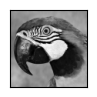

In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/'

fileNames = ["parrot.bmp", "clock.bmp", "chessboard.bmp", "bart.png", "firetruck.jpg", "lena.bmp"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)


I = cv2.imread('parrot.bmp')
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

I_width = I.shape[1]
I_height = I.shape[0]

plt.figure(figsize=(I_width/100, I_height/100))
plt.imshow(I, cmap ="gray")
plt.xticks([]), plt.yticks([])
plt.show()

2. Definiujemy funkcję do interpolacji metodą najbliższego sąsiada.

Jako argumenty wejściowe powinna ona przyjąć obraz oraz współczynniki skalowania w pionie i poziomie.
Wyjściem powinien być natomiast obraz w nowej rozdzielczości.
Wewnątrz należy:

* odczytać wymiary obrazka wejściowego,
* wyliczyć wymiary obrazka wyjściowego (tj. wymnożyć wymiary wejściowe przez skalę i zaokrąglić do liczb całkowitych),
* utworzyć nowy obraz o ww. rozmiarze,
* w pętli po nowym obrazie, dla każdego piksela, wykorzystując współczynniki skalowania, odnaleźć najbliższego sąsiada.




In [2]:
def NNInterpolation(image, scale_x, scale_y):
    original_width = image.shape[1]
    original_height = image.shape[0]

    new_width = round(original_width * scale_x)
    new_height = round(original_height * scale_y)

    result_image = np.zeros((new_height, new_width), dtype=image.dtype)

    for y in range(new_height):
        for x in range(new_width):
            original_x = round(x / scale_x)
            original_y = round(y / scale_y)

            original_x = min(original_x, original_width - 1)
            original_y = min(original_y, original_height - 1)

            result_image[y][x] = image[original_y][original_x]

    return result_image


3. Testujemy stworzoną funkcję:
    * dla skali 1.5, 1.5 i obrazka *parrot*,
    * dla 2.5, 2.5 - tu może okazać się, że do kodu trzeba dopisać zabezpieczenie przed wyjściem poza zakres,
    * dla niejednakowych skal np. 1.5 i 2.5,
    * dla skal mniejszych od 1,
    * dla niesymetrycznego obrazka *clock*,
    * dla obrazka z szachownicą *chessboard*.

Uwaga: proszę dla powyższych przypadków przygotować osobne sekcje kodu - tak, aby wyświetlały się wszystkie rozważane przypadki.

Wykonana metoda jest bardzo prosta i szybka, ale wprowadza pewne niepożądane artefakty, w szczególnie źle odwzorowane są linie proste.
Z drugiej strony sprawdza się w pewnych nietypowych przypadkach.
Zostanie to zademonstrowane w dalszej części ćwiczenia.

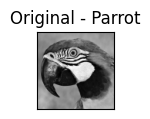

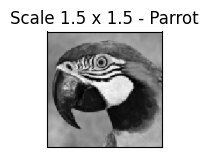

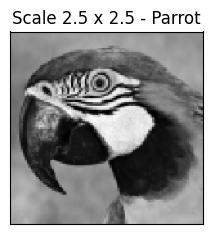

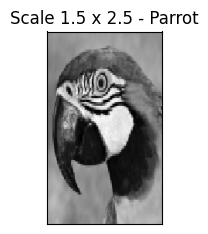

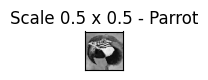

In [3]:
# Parrot
plt.figure(figsize=(I_width/100, I_height/100))
plt.title("Original - Parrot")
plt.imshow(I, cmap ="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_image_1 = NNInterpolation(I, 1.5, 1.5)
plt.figure(figsize=(scaled_image_1.shape[1]/100, scaled_image_1.shape[0]/100))
plt.title("Scale 1.5 x 1.5 - Parrot")
plt.imshow(scaled_image_1, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_image_2 = NNInterpolation(I, 2.5, 2.5)
plt.figure(figsize=(scaled_image_2.shape[1]/100, scaled_image_2.shape[0]/100))
plt.title("Scale 2.5 x 2.5 - Parrot")
plt.imshow(scaled_image_2, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_image_3 = NNInterpolation(I, 1.5, 2.5)
plt.figure(figsize=(scaled_image_3.shape[1]/100, scaled_image_3.shape[0]/100))
plt.title("Scale 1.5 x 2.5 - Parrot")
plt.imshow(scaled_image_3, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_image_4 = NNInterpolation(I, 0.5, 0.5)
plt.figure(figsize=(scaled_image_4.shape[1]/100, scaled_image_4.shape[0]/100))
plt.title("Scale 0.5 x 0.5 - Parrot")
plt.imshow(scaled_image_4, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

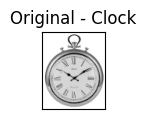

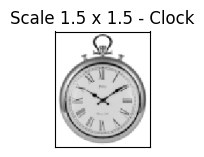

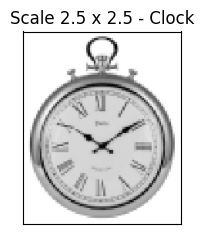

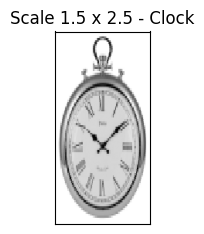

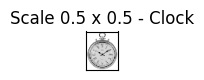

In [4]:
# Clock
I_clock = cv2.imread('clock.bmp')
I_clock = cv2.cvtColor(I_clock, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(I_clock.shape[1]/100, I_clock.shape[0]/100))
plt.title("Original - Clock")
plt.imshow(I_clock, cmap ="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_clock_1 = NNInterpolation(I_clock, 1.5, 1.5)
plt.figure(figsize=(scaled_clock_1.shape[1]/100, scaled_clock_1.shape[0]/100))
plt.title("Scale 1.5 x 1.5 - Clock")
plt.imshow(scaled_clock_1, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_clock_2 = NNInterpolation(I_clock, 2.5, 2.5)
plt.figure(figsize=(scaled_clock_2.shape[1]/100, scaled_clock_2.shape[0]/100))
plt.title("Scale 2.5 x 2.5 - Clock")
plt.imshow(scaled_clock_2, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_clock_3 = NNInterpolation(I_clock, 1.5, 2.5)
plt.figure(figsize=(scaled_clock_3.shape[1]/100, scaled_clock_3.shape[0]/100))
plt.title("Scale 1.5 x 2.5 - Clock")
plt.imshow(scaled_clock_3, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_clock_4 = NNInterpolation(I_clock, 0.5, 0.5)
plt.figure(figsize=(scaled_clock_4.shape[1]/100, scaled_clock_4.shape[0]/100))
plt.title("Scale 0.5 x 0.5 - Clock")
plt.imshow(scaled_clock_4, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

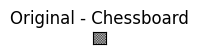

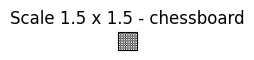

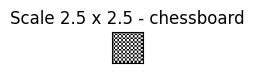

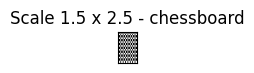

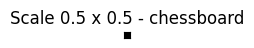

In [5]:
# Chessboard
I_chessboard = cv2.imread('chessboard.bmp')
I_chessboard = cv2.cvtColor(I_chessboard, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(I_chessboard.shape[1]/100, I_chessboard.shape[0]/100))
plt.title("Original - Chessboard")
plt.imshow(I_chessboard, cmap ="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_chessboard_1 = NNInterpolation(I_chessboard, 1.5, 1.5)
plt.figure(figsize=(scaled_chessboard_1.shape[1]/100, scaled_chessboard_1.shape[0]/100))
plt.title("Scale 1.5 x 1.5 - chessboard")
plt.imshow(scaled_chessboard_1, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_chessboard_2 = NNInterpolation(I_chessboard, 2.5, 2.5)
plt.figure(figsize=(scaled_chessboard_2.shape[1]/100, scaled_chessboard_2.shape[0]/100))
plt.title("Scale 2.5 x 2.5 - chessboard")
plt.imshow(scaled_chessboard_2, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_chessboard_3 = NNInterpolation(I_chessboard, 1.5, 2.5)
plt.figure(figsize=(scaled_chessboard_3.shape[1]/100, scaled_chessboard_3.shape[0]/100))
plt.title("Scale 1.5 x 2.5 - chessboard")
plt.imshow(scaled_chessboard_3, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_chessboard_4 = NNInterpolation(I_chessboard, 0.5, 0.5)
plt.figure(figsize=(scaled_chessboard_4.shape[1]/100, scaled_chessboard_4.shape[0]/100))
plt.title("Scale 0.5 x 0.5 - chessboard")
plt.imshow(scaled_chessboard_4, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

## Interpolacja dwuliniowa

W praktyce, lepszym rozwiązaniem zwykle okazuje tzw. **interpolacja dwuliniowa** (ang. *bilinear interpolation*).
Wykorzystuje ona informację o czterech najbliższych sąsiadach do określenia nowej wartości piksela.

Jeśli przez $(i,j)$ oznaczymy współrzędne poszukiwanego piksela, a przez $I(i,j)$ jego jasność (składową w odcieniach szarości) to jego wartość można obliczyć wykorzystując równanie:
\begin{equation}
I(i,j) = a \cdot i + b \cdot j+ c \cdot i \cdot j + d
\end{equation}
gdzie: współczynniki $a,b,c,d$ można wyliczyć na podstawie czterech najbliższych sąsiadów.

![Ilustracja dwuliniowej](https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/img/interABCD.png)

Prześledźmy to na przykładzie z powyższego rysunku.
Niech współrzędne poszczególnych punktów to $A = (j_1,i_1)$, $B = (j_1,i_2)$, $ C= (j_2,i_2)$ oraz $D = (j_2,i_1)$.
W pierwszej kolejności dokonujemy interpolacji wartości w punktach $AB$ i $CD$ -- czyli poziomo.
Wychodząc od równania prostej otrzymujemy:

\begin{equation}
f(AB) \approx \frac{i_2 - i}{i_2-i_1}f(A) + \frac{i - i_1}{i_2-i_1}f(B)
\end{equation}

\begin{equation}
f(CD) \approx \frac{i_2 - i}{i_2-i_1}f(D) + \frac{i - i_1}{i_2-i_1}f(C)
\end{equation}

Następnie wykonujemy analogiczną interpolację w pionie:
\begin{equation}
f(ABCD) \approx \frac{j_2 - j}{j_2-j_1}f(AB) + \frac{j - j_1}{j_2-j_1}f(CD)
\end{equation}

Łącząc powyższe równania otrzymujemy:
\begin{equation}
f(ABCD) \approx \frac{1}{(i_2 - i_1)(j_2-j_1)} ( f(A)(i_2-i)(j_2 - y) + f(B)(i-i_1)(j_2 - j) \\ + f(C)(i-i_1)(j-j_1) + f(D)(i_2-i)(j-j_1))
\end{equation}
gdzie zapis $f(X)$ oznacza wartość piksela w punkcie $X$.

Rozważania można uprościć przyjmując, że narożniki rozpatrywanego kwadratu mają następujące współrzędne: $A = (0,0)$, $B = (0,1)$, $ C= (1,1)$ oraz $D = (1,0)$.
Wtedy powyższe równanie można zapisać:
\begin{equation}
f(ABCD) \approx f(A)(1-i)(1-j) + f(B)i(1-j) + f(C)ij + f(D)(1-i)j
\end{equation}

lub macierzowo:
\begin{equation}
f(ABCD) \approx \begin{bmatrix}1 - i & i \end{bmatrix} \begin{bmatrix} f(A) & f(D) \\\\ f(B) & f(C)  \end{bmatrix}   \begin{bmatrix} 1-j \\\\ j  \end{bmatrix}
\end{equation}

Uwaga.
Nieco wbrew nazwie interpolacja dwuliniowa nie jest operacją liniową.
W złożeniu dwóch operacji liniowych pojawia się człon $xy$.

Warto dodać, że kolejny ``poziom wtajemniczenia'' to **interpolacja dwusześcienna** (ang. *bicubic interpolation*).
Dana jest ona wzorem:
\begin{equation}
I(i,j) = \sum_{i=0}^{3} \sum_{j=0}^{3} a_{ij} x^i y^j
\end{equation}
Jej implementacja stanowi zadanie domowe do bieżącego ćwiczenia.

Trzy powyżej przedstawione metody bynajmniej nie wyczerpują tematu.
Wystarczy choćby otworzyć stronę [wiki o skalowaniu](https://en.wikipedia.org/wiki/Image_scaling), by zobaczyć, że metod jest dużo więcej.




Wykorzystując powyższe równania zaimplementuj interpolację dwuliniową:
* dobrym punktem wyjścia będzie stworzona funkcja do interpolacji metodą najbliższego sąsiada,
* początek powinien być identyczny,
* różnice rozpoczynają się w momencie obliczenia współrzędnych nowego piksela,
* jeśli chcemy zastosować opisane powyżej wzory (w wariancie uproszczonym), to musimy wyliczyć współrzędne punktów $A,B,C,D$,
* w pierwszym kroku obliczamy współrzędne $A$ tj. $(0,0)$ - należy do tego wykorzystać funkcję *floor* (np. $i_1 = floor(i / h_{scale})$).
  Proszę ten krok odnieść do przedstawionego rysunku poglądowego,
* obliczenie współrzędnych $B,C,D$ jest już proste i sprowadza się do operacji `+1`,
* potrzebujemy jeszcze część ułamkową współrzędnych punktu $ABCD$ tj. $(i,j)$ - od ilorazu $i/h_{scale}$ należy odjąć wartość $i_1$
* wykorzystując wyznaczone współrzędne, należy pobrać wartości jasności w punktach $A,B,C,D$, tj. $f(A),f(B),f(C),f(D)$, podstawić do odpowiedniego równania i wykonać interpolację.

  Uwagi:
* Tworzenie macierzy *np.array*, mnożenie macierzy *np.dot*. Przy tworzeniu macierzy proszę zwrócić uwagę na niezbędne nawiasy kwadratowe.
* Przy próbie uruchomienia kodu pewnie okaże się, że wystąpi przekroczenie zakresu - należy dodać stosowne zabezpiczenie.

Proszę dla interpolacji dwuliniowej wykonać takie same eksperymenty, jak dla  najbliższego sąsiada.




In [6]:
import math

def BilinearInterpolation(image, scale_x, scale_y):
    original_width = image.shape[1]
    original_height = image.shape[0]

    new_width = round(original_width * scale_x)
    new_height = round(original_height * scale_y)

    result_image = np.zeros((new_height, new_width), dtype=image.dtype)

    for y in range(new_height):
        for x in range(new_width):
            original_x = x / scale_x
            original_y = y / scale_y

            # Współrzędne narożników
            i1 = math.floor(original_y)
            j1 = math.floor(original_x)
            i2 = min(i1 + 1, original_height - 1)
            j2 = min(j1 + 1, original_width - 1)

            # Jasności pikseli
            f_A = image[i1, j1]
            f_B = image[i1, j2]
            f_C = image[i2, j2]
            f_D = image[i2, j1]

            # Obliczenie części ułamkowej
            delta_x = original_x - j1
            delta_y = original_y - i1

            # Interpolacja pozioma
            f_AB = f_A * (1 - delta_x) + f_B * delta_x
            f_CD = f_D * (1 - delta_x) + f_C * delta_x

            # Interpolacja pionowa
            f_ABCD = f_AB * (1 - delta_y) + f_CD * delta_y

            result_image[y, x] = f_ABCD

    return result_image

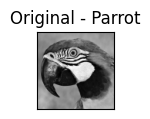

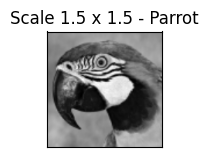

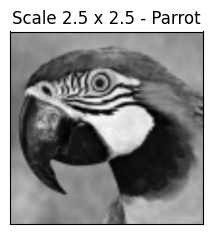

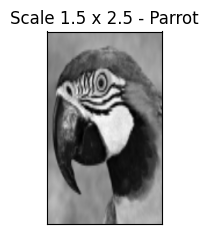

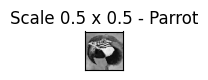

In [7]:
# Parrot
plt.figure(figsize=(I_width/100, I_height/100))
plt.title("Original - Parrot")
plt.imshow(I, cmap ="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_image_1 = BilinearInterpolation(I, 1.5, 1.5)
plt.figure(figsize=(scaled_image_1.shape[1]/100, scaled_image_1.shape[0]/100))
plt.title("Scale 1.5 x 1.5 - Parrot")
plt.imshow(scaled_image_1, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_image_2 = BilinearInterpolation(I, 2.5, 2.5)
plt.figure(figsize=(scaled_image_2.shape[1]/100, scaled_image_2.shape[0]/100))
plt.title("Scale 2.5 x 2.5 - Parrot")
plt.imshow(scaled_image_2, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_image_3 = BilinearInterpolation(I, 1.5, 2.5)
plt.figure(figsize=(scaled_image_3.shape[1]/100, scaled_image_3.shape[0]/100))
plt.title("Scale 1.5 x 2.5 - Parrot")
plt.imshow(scaled_image_3, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_image_4 = BilinearInterpolation(I, 0.5, 0.5)
plt.figure(figsize=(scaled_image_4.shape[1]/100, scaled_image_4.shape[0]/100))
plt.title("Scale 0.5 x 0.5 - Parrot")
plt.imshow(scaled_image_4, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

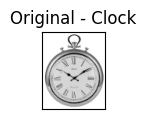

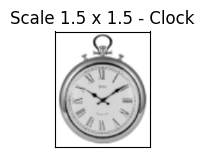

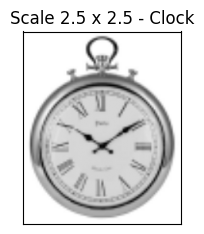

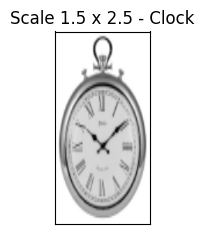

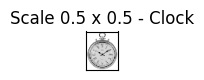

In [8]:
# Clock
plt.figure(figsize=(I_clock.shape[1]/100, I_clock.shape[0]/100))
plt.title("Original - Clock")
plt.imshow(I_clock, cmap ="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_clock_1 = BilinearInterpolation(I_clock, 1.5, 1.5)
plt.figure(figsize=(scaled_clock_1.shape[1]/100, scaled_clock_1.shape[0]/100))
plt.title("Scale 1.5 x 1.5 - Clock")
plt.imshow(scaled_clock_1, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_clock_2 = BilinearInterpolation(I_clock, 2.5, 2.5)
plt.figure(figsize=(scaled_clock_2.shape[1]/100, scaled_clock_2.shape[0]/100))
plt.title("Scale 2.5 x 2.5 - Clock")
plt.imshow(scaled_clock_2, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_clock_3 = BilinearInterpolation(I_clock, 1.5, 2.5)
plt.figure(figsize=(scaled_clock_3.shape[1]/100, scaled_clock_3.shape[0]/100))
plt.title("Scale 1.5 x 2.5 - Clock")
plt.imshow(scaled_clock_3, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_clock_4 = BilinearInterpolation(I_clock, 0.5, 0.5)
plt.figure(figsize=(scaled_clock_4.shape[1]/100, scaled_clock_4.shape[0]/100))
plt.title("Scale 0.5 x 0.5 - Clock")
plt.imshow(scaled_clock_4, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

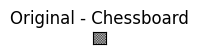

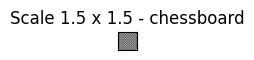

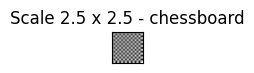

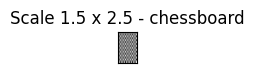

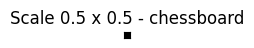

In [9]:
# Chessboard
I_chessboard = cv2.imread('chessboard.bmp')
I_chessboard = cv2.cvtColor(I_chessboard, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(I_chessboard.shape[1]/100, I_chessboard.shape[0]/100))
plt.title("Original - Chessboard")
plt.imshow(I_chessboard, cmap ="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_chessboard_1 = BilinearInterpolation(I_chessboard, 1.5, 1.5)
plt.figure(figsize=(scaled_chessboard_1.shape[1]/100, scaled_chessboard_1.shape[0]/100))
plt.title("Scale 1.5 x 1.5 - chessboard")
plt.imshow(scaled_chessboard_1, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_chessboard_2 = BilinearInterpolation(I_chessboard, 2.5, 2.5)
plt.figure(figsize=(scaled_chessboard_2.shape[1]/100, scaled_chessboard_2.shape[0]/100))
plt.title("Scale 2.5 x 2.5 - chessboard")
plt.imshow(scaled_chessboard_2, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_chessboard_3 = BilinearInterpolation(I_chessboard, 1.5, 2.5)
plt.figure(figsize=(scaled_chessboard_3.shape[1]/100, scaled_chessboard_3.shape[0]/100))
plt.title("Scale 1.5 x 2.5 - chessboard")
plt.imshow(scaled_chessboard_3, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

scaled_chessboard_4 = BilinearInterpolation(I_chessboard, 0.5, 0.5)
plt.figure(figsize=(scaled_chessboard_4.shape[1]/100, scaled_chessboard_4.shape[0]/100))
plt.title("Scale 0.5 x 0.5 - chessboard")
plt.imshow(scaled_chessboard_4, cmap="gray")
plt.xticks([]), plt.yticks([])
plt.show()

## Intepolacja w OpenCV

W OpenCV dostępna jest funkcja `resize`, która służy do zmiany rozmiaru obrazka.
Składnia jest następująca `dst = cv2.resize(src, dsize[, dst[, fx[, fy[, interpolation]]]] )`, gdzie `dst` to obraz wynikowy, `src` obraz źródłowy, `dsize` rozmiar docelowy (ew. można podać współczynniki skalowania dla poszczególnych osi: `fx,fy`), `interpolation` metoda interpolacji.
Metod podstawowych dostępnych jest 5:
- najbliższego sąsiada - ` cv2.INTER_NEAREST`,
- dwuliniowa - ` cv2.INTER_LINEAR`,
- dwukubiczna - ` cv2.INTER_CUBIC`,
- *area* - ` cv2.INTER_AREA`,
- *lanczos4* - ` cv2.INTER_LANCZOS4`.

Przeprowadzimy następujący eksperyment: obraz (o większej niż dotąd rozdzielczości) przeskalujemy każdą z metod -- zwiększymy i zmniejszymy jego rozdzielczość. Dodamy też pomiar czasu realizacji obliczeń.

Proszę stworzyć funkcję, która jako argumenty przyjmuje obraz oraz dwa współczynniki skalujące, a wewnątrz przeprowadzone zostaną interpolacje, pomiar czasu oraz wizualizacja (można wypisać czas w tytule rysunku).

Pomiar czasu:
```{python}
from timeit import default_timer as timer
start = timer()
# ...
end = timer()
print(end - start)
```

Wykonaj eksperyment dla kilku różnych skal, przeanalizuj czasy obliczeń.

In [10]:
from timeit import default_timer as timer

def OpenCVInterpolation(image, scale_x, scale_y):
    original_width = image.shape[1]
    original_height = image.shape[0]
    point = (original_width, original_height)

    fig, axs = plt.subplots(1, 5, figsize=(20, 10))

    start = timer()
    resized_image = cv2.resize(image, point, interpolation=cv2.INTER_NEAREST)
    end = timer()
    time = end - start
    axs[0].imshow(resized_image, cmap ="gray")
    axs[0].set_title(f"INTER_NEAREST: {time:.10f} s")
    axs[0].axis("off")


    start = timer()
    resized_image = cv2.resize(image, point, interpolation=cv2.INTER_LINEAR)
    end = timer()
    time = end - start
    axs[1].imshow(resized_image, cmap ="gray")
    axs[1].set_title(f"INTER_LINEAR: {time:.10f} s")
    axs[1].axis("off")


    start = timer()
    resized_image = cv2.resize(image, point, interpolation=cv2.INTER_CUBIC)
    end = timer()
    time = end - start
    axs[2].imshow(resized_image, cmap ="gray")
    axs[2].set_title(f"INTER_CUBIC: {time:.10f} s")
    axs[2].axis("off")


    start = timer()
    resized_image = cv2.resize(image, point, interpolation=cv2.INTER_AREA)
    end = timer()
    time = end - start
    axs[3].imshow(resized_image, cmap ="gray")
    axs[3].set_title(f"INTER_AREA: {time:.10f} s")
    axs[3].axis("off")


    start = timer()
    resized_image = cv2.resize(image, point, interpolation=cv2.INTER_LANCZOS4)
    end = timer()
    time = end - start
    axs[4].imshow(resized_image, cmap ="gray")
    axs[4].set_title(f"INTER_LANCZOS4: {time:.10f} s")
    axs[4].axis("off")
    plt.show()


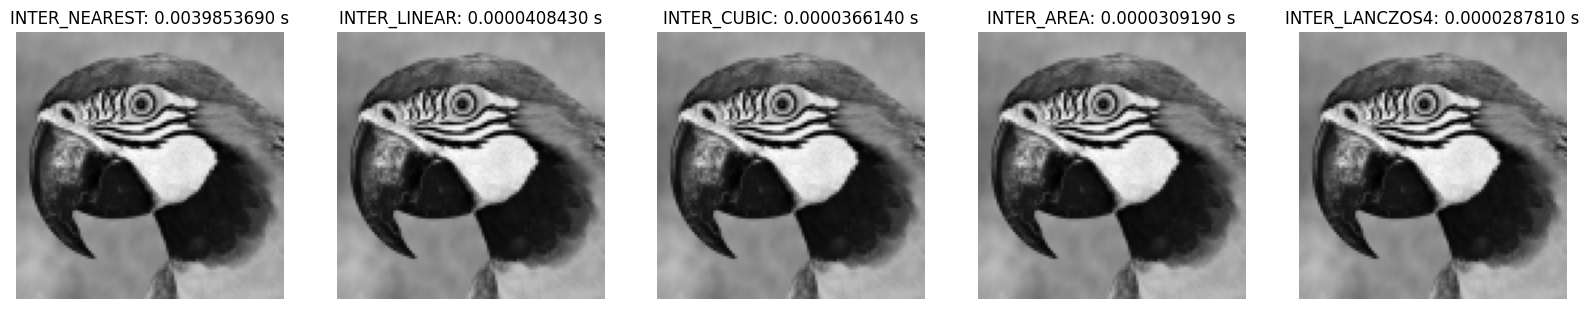

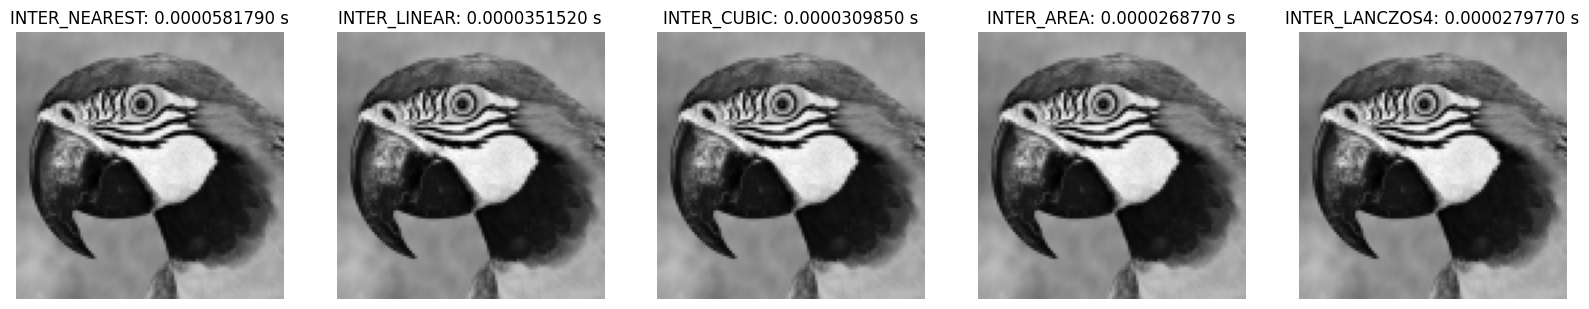

In [11]:
OpenCVInterpolation(I, 1.5, 1.5)
OpenCVInterpolation(I, 0.5, 0.5)

## Rozdzielczość (dpi)

Omówioną wcześniej rozdzielczość przestrzenną (rozmiar) należy utożsamiać z rozmiarem macierzy w której zapisany jest obraz.
W tym ujęciu rozmiar pojedynczego piksela nie ma specjalnego znaczenia.
Problem pojawia się, kiedy obraz trzeba wyświetlić lub wydrukować.
Wtedy pojedynczy piksel staje się ,,obiektem fizycznym'' i musi mieć swój rozmiar (wysokość/szerokość/powierzchnię).

Parametr dpi (ang. *dots per inch*) określa liczbę kropek (pikseli), która mieści się na jednym calu (25,4 mm) długości/szerokości.
Dopiero kombinacja rozmiaru i rozdzielczości określa nam rzeczywisty rozmiar obrazu jaki uzyskamy na wydruku.

Dpi staje się istotne w przypadku drukowania, gdyż wyświetlanie na monitorze odbywa się zazwyczaj 1 piksel obrazka = 1 piksel na monitorze (w przypadku maksymalnej rozdzielczości wspieranej przez monitor), ew. następuje automatyczne skalowanie.

Wpływ rozdzielczości można zademonstrować w następujący sposób:
- wczytaj obraz *lena.bmp*.  Ma on rozmiar $512 \times 512$.
- wykorzystując funkcję `imresize` stwórz obrazy o rozmiarach $256 \times 256$, $128 \times 128$, $64 \times 64$ - metoda interpolacji jest w tym wypadku mniej istotna.
- wyświetl obrazy wymuszając zachowanie na ekranie wejściowej rozdzielczości $512 \times 512$. W przypadku biblioteki *matplotlib* ta funkcjonalność jest domyślna.

Proszę zaobserwować co dzieję się z obrazkiem.

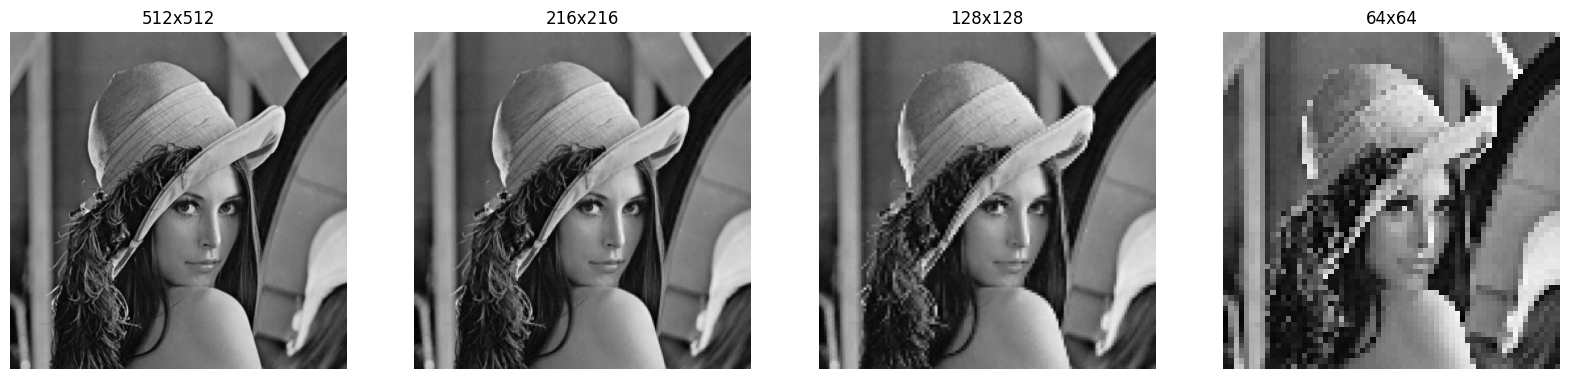

In [12]:
I = cv2.imread('lena.bmp')
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

image_1 = cv2.resize(I, (256, 256))
image_2 = cv2.resize(I, (128, 128))
image_3 = cv2.resize(I, (64, 64))

fig, axs = plt.subplots(1, 4, figsize=(20, 10))

axs[0].set_title('512x512')
axs[0].axis("off")
axs[0].imshow(I, 'gray')

axs[1].set_title('216x216')
axs[1].axis("off")
axs[1].imshow(image_1, 'gray')

axs[2].set_title('128x128')
axs[2].axis("off")
axs[2].imshow(image_2, 'gray')

axs[3].set_title('64x64')
axs[3].axis("off")
axs[3].imshow(image_3, 'gray')

## Liczba poziomów jasności

Dla obrazów w skali szarości pojedynczy piksel zwykle zapisuje się na 8 bitach, co daje 256 rozróżnialnych poziomów szarości.
Dla większości zastosowań wartość ta jest wystarczająca (choć są kamery o wyjścu 12 lub 16 bitów).
Jednak oko ludzkie nie potrafi rozróżnić wszystkich 256 poziomów jasności (jest za mało czułe).
Zazwyczaj człowiek rozróżnia 20-30 poziomów szarości (to ile i jakie dokładnie rozróżnia, zależy od konkretnego oświetlenia sceny i cech osobniczych).

W poniższych krokach zademonstrujemy omówione zjawisko:
- wczytaj (użyj) obrazu _lena_,
- wykorzystując znaną funkcję `normalize` zmień liczbę poziomów szarości z 0-255 na:
    * 0-31
    * 0-15
    * 0-7
    * 0-3
    * 0-1 (binaryzacja)
- rezultaty wyświetl na wspólnym rysunku.

Podpowiedzi:
- trzeba przygotować tablice na obrazki np, `I_31 = np.zeros(I.shape,'uint8')`,
- prawidłowe użycie funkcji normalize `cv2.normalize(I,I_31,0,31,cv2.NORM_MINMAX)`,
- przykładowe wyświetlanie `axsHist[0,1].imshow(I, 'gray', vmin=0, vmax=31)`.

Czy rezultaty eksperymentu pasują do teorii o rozpoznawaniu przez człowieka ograniczonego zakresu poziomów jasności?
Wizualne porównanie których obrazów o tym świadczy?

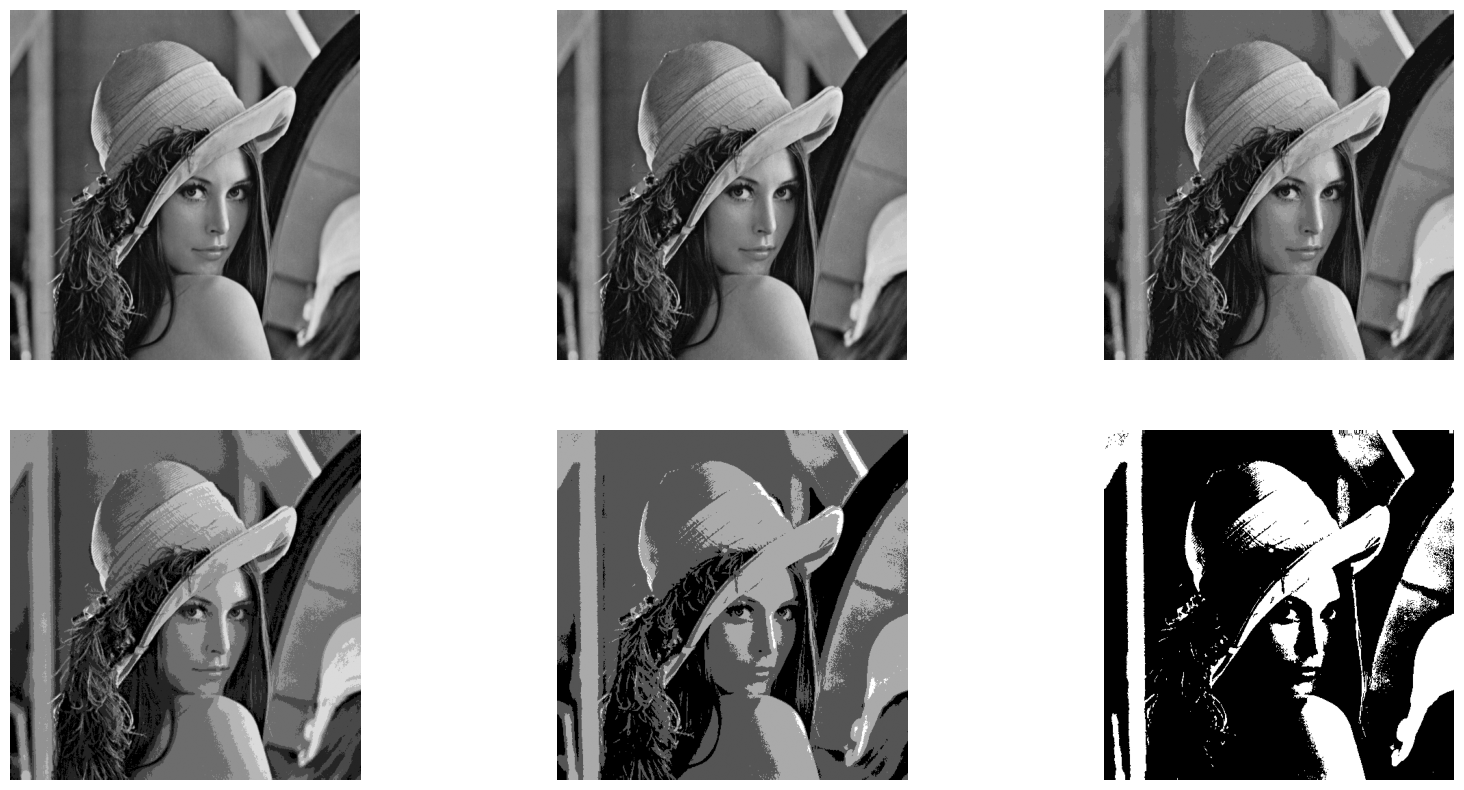

In [13]:
I = cv2.imread("lena.bmp")
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

I_31 = np.zeros(I.shape, "uint8")
I_15 = np.zeros(I.shape, "uint8")
I_7 = np.zeros(I.shape, "uint8")
I_3 = np.zeros(I.shape, "uint8")
I_1 = np.zeros(I.shape, "uint8")

cv2.normalize(I, I_31, 0, 31, cv2.NORM_MINMAX)
cv2.normalize(I, I_15, 0, 15, cv2.NORM_MINMAX)
cv2.normalize(I, I_7, 0, 7, cv2.NORM_MINMAX)
cv2.normalize(I, I_3, 0, 3, cv2.NORM_MINMAX)
cv2.normalize(I, I_1, 0, 1, cv2.NORM_MINMAX)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs[0, 0].imshow(I, cmap="gray")
axs[0, 0].axis("off")
axs[0, 1].imshow(I_31, cmap="gray")
axs[0, 1].axis("off")
axs[0, 2].imshow(I_15, cmap="gray")
axs[0, 2].axis("off")
axs[1, 0].imshow(I_7, cmap="gray")
axs[1, 0].axis("off")
axs[1, 1].imshow(I_3, cmap="gray")
axs[1, 1].axis("off")
axs[1, 2].imshow(I_1, cmap="gray")
axs[1, 2].axis("off")
plt.show()